In [1]:
from XRDXRFutils import DataXRD, DatabaseXRD, SpectraXRD, GaussNewton

import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import re

# Read phase database

In [2]:
#path_phases = 'Database'
path_phases = '../../dati/Database/'
database = DatabaseXRD().read_cifs(path_phases)
phase_chosen = database['Calcite'][0]
calibration_right = np.array([-741.96144778, 2803.29875555, 31.09111973])

# Create experimental spectrum

In [108]:
min_theta = 16
max_theta = 42
min_intensity = None

g_experimental = 1
rescale_peak_experimental = GaussNewton.w(g_experimental)
tau_experimental = 0.3
shift_angle = -0.4

print(f'Tau of experimental spectrum: {tau_experimental}')
print(f'Sigma^2 of experimental spectrum: {GaussNewton.u(tau_experimental)}')
print(f'Sigma of experimental spectrum: {np.sqrt(GaussNewton.u(tau_experimental))}')

spectrum_dummy = SpectraXRD().from_array(np.ones(1280))
spectrum_dummy.opt = calibration_right
fit_dummy = GaussNewton(phase_chosen, spectrum_dummy, min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity)
fit_dummy.tau = np.full_like(fit_dummy.tau, tau_experimental)
fit_dummy.mu = fit_dummy.get_theta(min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity)[0] + shift_angle
spectrum_sample = SpectraXRD().from_array(fit_dummy.z())
spectrum_sample.opt = calibration_right
spectrum_sample.intensity = fit_dummy.z() / fit_dummy.z().max()

Tau of experimental spectrum: 0.3
Sigma^2 of experimental spectrum: 0.09
Sigma of experimental spectrum: 0.3


# Gauss-Newton

In [137]:
fit_sample = GaussNewton(phase_chosen, spectrum_sample, min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity)
fit_sample.I /= rescale_peak_experimental

In [135]:
for idx in range(1):
    fit_sample.fit(a = True, s = True, gamma = True, sigma = True)
    #fit_sample.fit(a = True, s = True, gamma = True)
    #fit_sample.fit(a = True, s = True)
    #fit_sample.fit(sigma = True)

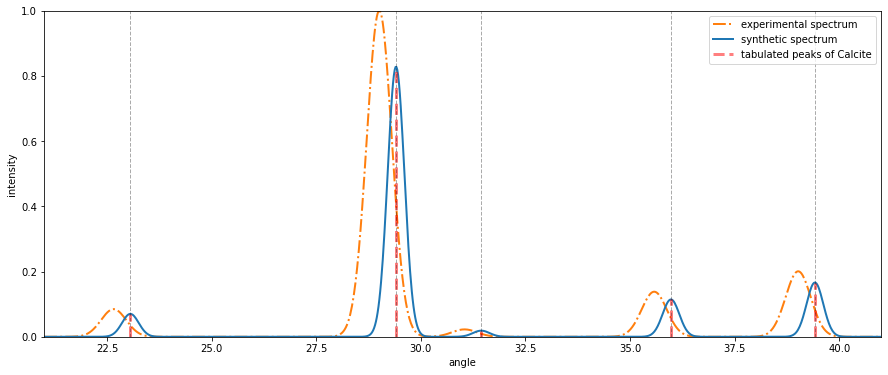

Fit error = 0.12812366025541796
Calibration parameters = [-741.96144778 2803.29875555   31.09111973]
tau = [[0.2 0.2 0.2 0.2 0.2]]
sigma2 = [[0.04 0.04 0.04 0.04 0.04]]
sigma = [[0.2 0.2 0.2 0.2 0.2]]


In [139]:
fig, ax = plt.subplots(figsize = (15, 6))
ax.plot(fit_sample.theta, fit_sample.intensity, ls = '-.', lw = 2, c = 'tab:orange', label = 'experimental spectrum')
ax.plot(fit_sample.theta, fit_sample.z(), ls = '-', lw = 2, c = 'tab:blue', label = 'synthetic spectrum')
ax.vlines(fit_sample.mu, 0, fit_sample.I, 'r', alpha = 0.5, ls = '--', lw = 3, label = 'tabulated peaks of ' + phase_chosen['_chemical_name_mineral'])
ax.vlines(fit_sample.mu, 0, 1, 'k', alpha = 0.33, ls = '--', lw = 1)
ax.set_xlabel('angle')
ax.set_ylabel('intensity')
ax.legend()
ax.set_xlim(21, 41)
ax.set_ylim(0, 1)
plt.show()

print(f'Fit error = {fit_sample.fit_error()}')
print(f'Calibration parameters = {fit_sample.opt}')
print(f'tau = {fit_sample.tau}')
print(f'sigma2 = {fit_sample.sigma2}')
print(f'sigma = {np.sqrt(fit_sample.sigma2)}')

# Manipulate the fitting spectrum

In [38]:
# Set right calibration
fit_sample.opt = calibration_right + np.array([0, 0, -shift_angle])

In [72]:
# Set right gamma
fit_sample.g = np.full_like(fit_sample.g, g_experimental)

In [127]:
# Set right sigma
fit_sample.tau = np.full_like(fit_sample.g, tau_experimental)